In [1]:
%matplotlib nbagg
import numpy as np
import json
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display

from alvra_tools.load_data import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm, threshold
import glob

In [2]:
scan_name ="SiN_timingHe_3"
DIR_json = "/sf/alvra/data/p18182/res/scan_info/"
DIR = "/sf/alvra/data/p18182/raw/scan_data/" + scan_name + "/"             #use this for a scan

#######################################################################

files_scan = glob.glob(DIR_json + scan_name + '.*')
print (files_scan)
scan_range = '.'+files_scan[-1].split('.')[-2]
print (scan_range)

!ls -lah -rt $DIR | grep BSREAD.h5
!hostname

['/sf/alvra/data/p18182/res/scan_info/SiN_timingHe_3.run000384-000445.json']
.run000384-000445
-rw-r--r--.  1 root p18182  36M Jan 26 10:09 run_000384.BSREAD.h5
-rw-r--r--.  1 root p18182  36M Jan 26 10:09 run_000385.BSREAD.h5
-rw-r--r--.  1 root p18182  36M Jan 26 10:09 run_000386.BSREAD.h5
-rw-r--r--.  1 root p18182  36M Jan 26 10:09 run_000387.BSREAD.h5
-rw-r--r--.  1 root p18182  36M Jan 26 10:10 run_000388.BSREAD.h5
-rw-r--r--.  1 root p18182  36M Jan 26 10:10 run_000389.BSREAD.h5
-rw-r--r--.  1 root p18182  36M Jan 26 10:10 run_000390.BSREAD.h5
-rw-r--r--.  1 root p18182  36M Jan 26 10:11 run_000391.BSREAD.h5
-rw-r--r--.  1 root p18182  36M Jan 26 10:11 run_000392.BSREAD.h5
-rw-r--r--.  1 root p18182  36M Jan 26 10:11 run_000393.BSREAD.h5
-rw-r--r--.  1 root p18182  36M Jan 26 10:11 run_000394.BSREAD.h5
-rw-r--r--.  1 root p18182  36M Jan 26 10:12 run_000395.BSREAD.h5
-rw-r--r--.  1 root p18182  36M Jan 26 10:12 run_000396.BSREAD.h5
-rw-r--r--.  1 root p18182  36M Jan 26 10:12 ru

### Next cell: Signal calculated Shot-to-shot and averaged

In [3]:
quantile_laser = 0.5

########################################################################
json_file = DIR_json + scan_name + scan_range + ".json"

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1
print ("Processing",numFiles,"files")
print (json_file)

Pump_probe_all = []
Pump_probe = []
Pump_probe_avg =[]
Delay_mm = []

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])
    testdata = check_files_and_data(filename)

    if (testdata):# and (i!=12):
        clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        
        (Laser_pump, Laser_unpump, Laser_ref_pump, Laser_ref_unpump, Izero_FEL, PIPS, delay, pids_loop) = \
        load_YAG_events(str(data['scan_files'][i][0]))
        
        #Laser_diff = -np.log10((Laser_pump/Laser_ref_pump) / (Laser_unpump/ Laser_ref_unpump))
        Laser_diff = -np.log10((Laser_pump) / (Laser_unpump))
        #Laser_diff = ((Laser_pump) / (Laser_unpump))
        Pump_probe_all.append(Laser_diff)
        df_pump_probe = pd.DataFrame(Laser_diff)
        Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_laser/2, 0.5 + quantile_laser/2]))
            
        Pump = np.median(Laser_pump)
        Unpump = np.median(Laser_unpump)
        Pump_probe_avg.append(-np.log10((Pump) / (Unpump)))
        
        Delay_mm.append(data['scan_readbacks'][i]) ## Delay from the json file

Pump_probe_all = np.asarray(Pump_probe_all)
Pump_probe = np.asarray(Pump_probe)
Pump_probe_avg = np.asarray(Pump_probe_avg)

Delay_mm = np.asarray(Delay_mm)
print ("PBPS data of the last step have {} shots, avg intensity = {} +/- {}".format(len(Izero_FEL),round(np.average(Izero_FEL),4), round(np.std(Izero_FEL),4)))
print ("Quantile range = {}".format(0.5 - quantile_laser/2), 0.5 + quantile_laser/2)
print ("Loaded {} files, size of the arrays = {}".format(numFiles, len(Pump_probe)))


step 61 of 61 : Processing /sf/alvra/data/p18182/raw/scan_data/SiN_timingHe_3/run_000444.BSREAD.h5
Found 499 shots in the file
Load 498 shots
Pump/umpump arrays have 249 shots each
PBPS data of the last step have 249 shots, avg intensity = 2.3014 +/- 0.0793
Quantile range = 0.25 0.75
Loaded 61 files, size of the arrays = 60


 ### Plot pump probe signals as a function of delay (stage mm)

In [4]:
pp = Pump_probe[:,0]
err_pp_low = Pump_probe[:,1]
err_pp_high = Pump_probe[:,2]

plt.figure(figsize = (11,5))
plt.suptitle (scan_name + scan_range)
plt.subplot(131)
for i in range(len(Delay_mm)):
    xe = Delay_mm[i]
    ye = Pump_probe_all[i,:]
    plt.plot([xe] * len(ye), ye, 'r.', ms=.5, alpha=0.8)
plt.plot(Delay_mm, pp, label='shot-to-shot, {}%'.format(quantile_laser*100), marker='.')
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.grid()

plt.subplot(132)
plt.plot(Delay_mm, pp, label='shot-to-shot, {}%'.format(quantile_laser*100), marker='.')
plt.fill_between(np.squeeze(Delay_mm), err_pp_low, err_pp_high, color='lightblue')
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.grid()

plt.subplot(133)
plt.plot(Delay_mm, Pump_probe_avg, label="averaged", color = 'r', marker='.')
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.grid()
plt.show()
#plt.savefig(savedir + 'LAMcheck_026')

<IPython.core.display.Javascript object>

 ### Extract t0 from the fit 

In [5]:
# Get a rough estimate of timezero in mm from the plot just above.
Timezero = 163.03148

Pump_probe_toFit = pp.copy()
Delay_mm_toFit = np.copy(Delay_mm.ravel())
Delay_ps_toFit = (Delay_mm_toFit - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !

In [6]:
# Now fit with error funciton
index = ~(np.isnan(Delay_mm_toFit) | np.isnan(Pump_probe_toFit))

parameters_mm,extras = curve_fit(errfunc_fwhm, Delay_mm_toFit[index], Pump_probe_toFit[index], p0 = [0, 0.2, Timezero, 0.5])
t0_mm = parameters_mm[2]
width_mm = parameters_mm[3]

print("Position t0 =",np.round(t0_mm,5),"mm")
print("Width =",np.abs(np.round(width_mm,3))*1000,"um")

Position t0 = 163.03148 mm
Width = 29.0 um


In [7]:
# Now fit IN TIME with error funciton (defined above)
index = ~(np.isnan(Delay_ps_toFit) | np.isnan(Pump_probe_toFit))
parameters_ps,extras = curve_fit(errfunc_fwhm, Delay_ps_toFit[index], Pump_probe_toFit[index], p0 = [0, 0.2, 0, 100])
t0_ps = parameters_ps[2]
width_ps = parameters_ps[3]

print("Position t0 =",np.round(t0_ps,5),"ps")
print("Width =",np.abs(np.round(width_ps,5))*1000,"fs")

Position t0 = -2e-05 ps
Width = 192.54 fs


In [9]:
#... and the plot with the fit curves

plt.figure(figsize = (10,5))
plt.suptitle (scan_name + scan_range)
plt.subplot(121)

plt.plot(Delay_mm_toFit, pp, label='pump probe, {}%'.format(quantile_laser*100),marker='.')
plt.fill_between(np.squeeze(Delay_mm_toFit), err_pp_low, err_pp_high, color='lightblue')
plt.plot(Delay_mm_toFit, errfunc_fwhm(Delay_mm_toFit,*parameters_mm))
plt.grid()
plt.xlabel("delay (mm)")
plt.legend(loc="best")
plt.gca().set_title('Pump-probe vs Delay (mm)')
plt.legend(loc="best")
plt.title('t0=' + str(np.round(t0_mm, 5)) + ' mm' )


plt.subplot(122)

plt.plot(Delay_ps_toFit*1000, pp, label='pump probe, {}%'.format(quantile_laser*100),marker='.')
plt.fill_between(np.squeeze(Delay_ps_toFit*1000), err_pp_low, err_pp_high, color='lightblue')
plt.plot(Delay_ps_toFit*1000, errfunc_fwhm(Delay_ps_toFit,*parameters_ps))
plt.grid()
plt.xlabel("delay (fs)")
plt.legend(loc="best")
plt.gca().set_title('width = {} fs'.format(np.abs(round(width_ps, 5))*1000))
plt.legend(loc="best")
#plt.title('width=' + str(np.round(width_ps_ps, 5)) + ' fs' )

print ('t0 = {} mm'.format(np.round(t0_mm, 5)))
plt.show()

<IPython.core.display.Javascript object>

t0 = 163.03148 mm


# From here with TT (PALM) jitter correction

In [11]:
import photodiag

#DIRcalib = '/sf/photo/src/PALM/calib/'
#DIRcalib = '/sf/photo/src/PALM/calib/Alvra'
DIRcalib = '/sf/alvra/data/p18182/res/PhotoDiag/scan_info/'

CalibrationFn = DIRcalib + '2020-01-25_16:28:32.palm_etof'

energyFrom =  8400
energyTo =    8600
energySteps = 2000
palm = photodiag.PalmSetup({'0': 'SAROP11-PALMK118:CH1_BUFFER', '1': 'SAROP11-PALMK118:CH2_BUFFER'},
                 noise_range=[0, 250],
                 energy_range=np.linspace(energyFrom, energyTo, energySteps))

palm.load_etof_calib(CalibrationFn)

In [12]:
quantile_laser = 0.5
ev2fsCalib= -20.723024835035712    # This is from THz scan_508
Timezero = 163.03148              # This is from above
modulo = 2                        # This is for FEL/50Hz -- laser/100Hz
                
########################################################################


###########################################################################################
from alvra_tools.load_data import _cut_to_shortest_length, _average
json_file = DIR_json + scan_name + scan_range + ".json"

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1
print ("Processing",numFiles,"files")
print (json_file)

Pump_probe = []
Pump_probe_avg =[]
Pump_probe_all = []
Delays_stage_mm = []
Delays_PALM_all = []

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])
    testdata = check_files_and_data(filename)

    if (testdata):# and (i!=12):
        clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        
        # Load pump probe data:
        (Laser_pump, Laser_unpump, Laser_ref_pump, Laser_ref_unpump, Izero_FEL, PIPS, delays_stage_mm, pids_loop) = \
        load_YAG_events(filename)
        
        # Load PALM data:
        pulse_id_PALM, delays_PALM_eV, _, (input_data, lags, cross_corr, _) = palm.process_hdf5_file(filename, debug=True)
       
        # Load pump-unpump scheme:
        reprate_light, reprate_dark = load_reprates_YAG(filename, modulo=modulo)
        
        if ((len(pulse_id_PALM)) != (len(pids_loop)*modulo)):            
            pulse_id_PALM = pulse_id_PALM[:len(pids_loop)*modulo]
            delays_PALM_eV = delays_PALM_eV[:len(pids_loop)*modulo]
            cross_corr = cross_corr[:len(pids_loop)*modulo]
            input_data_0 = input_data['0'][:][:len(pids_loop)*modulo]
            input_data_1 = input_data['1'][:][:len(pids_loop)*modulo]
        
        delays_PALM_fs = delays_PALM_eV * ev2fsCalib
        
        #Laser_diff = -np.log10((Laser_pump/Laser_ref_pump) / (Laser_unpump/ Laser_ref_unpump))
        Laser_diff = -np.log10((Laser_pump) / (Laser_unpump))
        #Laser_diff = ((Laser_pump) / (Laser_unpump))
        #delays_stage_fs =(delays_stage_mm - Timezero)*2/(3e8*1e3*1e-15) # change to right t0 !
        
        beamOK = (np.amax(input_data_0,axis=1) > 0.0)# & (delays !=0.0)
        
        delays_beamOK_light = delays_PALM_fs[beamOK & reprate_light]
        pulse_id_PALM = pulse_id_PALM[beamOK & reprate_light]
#        Laser_diff = Laser_diff[beamOK & reprate_light]
                       
        df_pump_probe = pd.DataFrame(Laser_diff)
        Pump_probe.append(np.quantile(df_pump_probe, [0.5, 0.5 - quantile_laser/2, 0.5 + quantile_laser/2]))
            
        Pump = np.median(Laser_pump)
        Unpump = np.median(Laser_unpump)
        Pump_probe_avg.append(-np.log10((Pump) / (Unpump)))
        
        Delays_stage_mm.append(data['scan_readbacks'][i]) ## Delay from the json file
        Delays_PALM_all.append(delays_beamOK_light)
        
        Pump_probe_all.append(Laser_diff)

Pump_probe = np.asarray(Pump_probe)
Pump_probe_avg = np.asarray(Pump_probe_avg)
Pump_probe_all = np.asarray(Pump_probe_all)
Delays_stage_mm = np.asarray(Delays_stage_mm)
Delays_PALM_all = np.asarray(Delays_PALM_all)
        
Delays_stage_fs = (Delays_stage_mm - Timezero)*2/(3e8*1e3*1e-15) # change to right t0 !

print ("PBPS data of the last step have {} shots, avg intensity = {} +/- {}".format(len(Izero_FEL),round(np.average(Izero_FEL),4), round(np.std(Izero_FEL),4)))
print ("Quantile range = {}".format(0.5 - quantile_laser/2), 0.5 + quantile_laser/2)
print ("Loaded {} files, size of the arrays = {}".format(numFiles, len(Pump_probe)))

step 61 of 61 : Processing /sf/alvra/data/p18182/raw/scan_data/SiN_timingHe_3/run_000444.BSREAD.h5
Found 499 shots in the file
Load 498 shots
Pump/umpump arrays have 249 shots each
Found 499 shots in the file
Load 498 shots
PBPS data of the last step have 249 shots, avg intensity = 2.3014 +/- 0.0793
Quantile range = 0.25 0.75
Loaded 61 files, size of the arrays = 60


In [68]:
np.std(Delays_PALM_all[0,:]-Delays_PALM_all.mean())

25.073409581857103

<IPython.core.display.Javascript object>


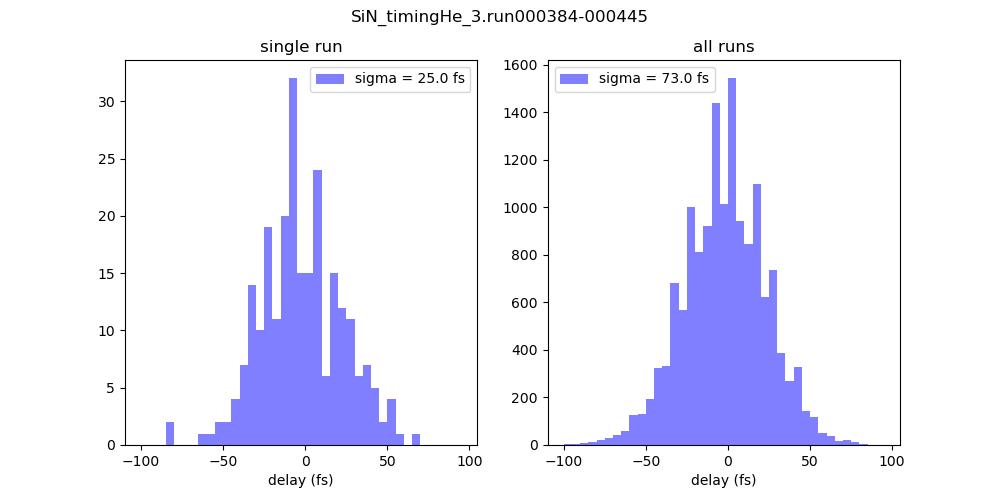

In [84]:
plt.figure(figsize=(10,5))
plt.suptitle(scan_name + scan_range)

plt.subplot(121)
plt.hist((Delays_PALM_all[0,:]-Delays_PALM_all.mean()), bins =np.arange(-100,100,5), facecolor='blue', label="sigma = {} fs".format(np.round(np.std(Delays_PALM_all[0,:]-Delays_PALM_all.mean()))), alpha=0.5)
plt.title('single run')
plt.legend(loc="best")
plt.xlabel ('delay (fs)')
plt.show()

plt.subplot(122)
plt.hist((Delays_PALM_all.ravel()-Delays_PALM_all.mean()), bins =np.arange(-100,100,5), facecolor='blue', label="sigma = {} fs".format(np.round(np.std(Delays_PALM_all.ravel()-Delays_PALM_all.mean()))), alpha=0.5)
plt.title('all runs')
plt.legend(loc="best")
plt.xlabel ('delay (fs)')
plt.show()


#plt.hist(DataFluo_pump_shot_raw, bins =np.arange(-0.5,0.85,0.01), facecolor='blue', label="fluo pump raw", alpha=0.5)


In [54]:
def CorrectJitterSignal(DelaysPALM_fs, DelaysSTAGE_fs, Signal, reBinFac, quantile_rebin):
    print (DelaysPALM_fs.shape, DelaysSTAGE_fs.shape, Signal.shape)
    #Delaystmp = DelaysRAW#*calibPALM
    CorrectedTime = DelaysSTAGE_fs + ((DelaysPALM_fs)-(DelaysPALM_fs.mean()))
    PALMSteps =  DelaysSTAGE_fs.shape[0]*reBinFac
    CorrectedTime = CorrectedTime.ravel()
    binsCentre = np.linspace(DelaysSTAGE_fs[0], DelaysSTAGE_fs[-1], PALMSteps)
    
    digi = np.digitize(CorrectedTime, binsCentre[:,0])
    
    signalProc = []
    signalProcSS = []
    Num_points = []
    
    for i in range(PALMSteps):
        ind = digi==i+1
        num_points = np.count_nonzero(ind)
        #signalProc.append(np.nanmedian(Signal[ind]))
        signalProcSS.append(Signal[ind])
        Num_points.append(num_points)
        df_signal = pd.DataFrame(Signal[ind])
        signalProc.append(np.nanquantile(df_signal, [0.5, 0.5 - quantile_rebin/2, 0.5 + quantile_rebin/2]))
        
        
    signalProc= np.array(signalProc)
    signalProcSS= np.array(signalProcSS)
    Num_points = np.asarray(Num_points)

    return binsCentre, CorrectedTime, signalProc, signalProcSS, Num_points

In [55]:
quantile_reBin = 0.4
reBin_factor = 4

############################################################################

BinsCentre, CorrectedTime, Signal, SignalSS, ShotsPerBin = \
CorrectJitterSignal(Delays_PALM_all, Delays_stage_fs, Pump_probe_all.ravel(), reBin_factor, quantile_reBin)

(60, 249) (60, 1) (14940,)
60


In [47]:
sig = Signal[:,0]
err_sig_low = Signal[:,1]
err_sig_high = Signal[:,2]

plt.figure(figsize = (8,5))
plt.title (scan_name + scan_range)
#for i in range(len(BinsCentre)):
#    xe = BinsCentre[i]
#    ye = SigSS[i]
#    plt.plot([xe] * ShotsPerBin[i], ye, 'r.', ms=.5, alpha=0.8)
plt.plot (np.squeeze(BinsCentre), sig, label='Re-binned factor {}, {}%  '.format(reBinFac, quantile_reBin*100), marker = '.')
plt.fill_between(np.squeeze(BinsCentre), err_sig_low, err_sig_high, color='lightblue',  alpha = 0.5)
plt.plot(Delay_ps_toFit*1000, pp, label='original, {}%'.format(quantile_laser*100),marker='.')
#plt.fill_between(np.squeeze(Delay_ps_toFit*1000), err_pp_low, err_pp_high, color='navajowhite',  alpha = 0.3)
plt.legend(loc="best")
plt.xlabel("delay (fs)")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>

In [46]:
sum(ShotsPerBin) - 249*60

-166

In [42]:
plt.figure()
plt.plot (ShotsPerBin)
plt.show()

<IPython.core.display.Javascript object>

In [ ]:
time_zero =  149.6658   #this is in mm from the delay scans (offset of 70 um due to air vs He[100 mbar])

desidered_delay = 3        #choose this in ps

delay_to_set = (100/(2*333))*desidered_delay + time_zero        #factor of 2 because of the delay stage

desidered_delay + time_zero
print ("To be at",desidered_delay,"ps, put the laser pump delay stage to",np.round(delay_to_set,4),"mm")

In [ ]:
offset_space = 50       # this is in um

offset_time = 2*(offset_space * 1e-6)/3e8/1e-15            #factor of 2 because of the delay stage, results in fs
print ("An offset of",offset_space,"um corresponds to an offset of",np.round(offset_time,4),"fs")

In [ ]:
offset_time = 140      # this is in fs

offset_space = 3e8 * (offset_time * 1e-15)/2/1e-6          #factor of 2 because of the delay stage, results in um
print ("An offset of",offset_time,"fs corresponds to an offset of",np.round(offset_space,4),"um")

In [ ]:
195.2-(105.9-88.35)

In [ ]:
# Check if the condition on the intensity makes sense by looking at the total histogram. §

Izero_total_1D = np.hstack(Izero_FEL_all)
Izero_total_1D_filter = np.hstack(Izero_FEL_all_filter)

print ("Total shots=",Izero_total_1D.size,"// filtered=,",Izero_total_1D_filter.size)
plt.figure()

### ALL STEPS ###
plt.hist(Izero_total_1D_filter, bins = np.arange(0,2,0.01), facecolor='red', alpha=0.5)
plt.hist(Izero_total_1D, bins = np.arange(0,2,0.01), facecolor='blue', alpha=0.5)

### ONLY THE LAST STEP ###
#plt.hist(Izero_FEL, bins = np.arange(0,1.5,0.01), facecolor='blue', alpha=0.5)
#plt.hist(Izero_FEL_filter, bins = np.arange(0,1.5,0.01), facecolor='orange', alpha=0.5)

plt.xlim(0,2)
plt.title(DIR)

plt.show()